## part4: Paper Implementaion

import libraries

In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import datsets

In [2]:
df_entities = pd.read_csv('entities.csv')

In [3]:
df_companies = pd.read_csv('companies.csv')

In [5]:
df_tweets = pd.read_csv('tweets.csv')

### Cashtag-cloud of most tweeted companies

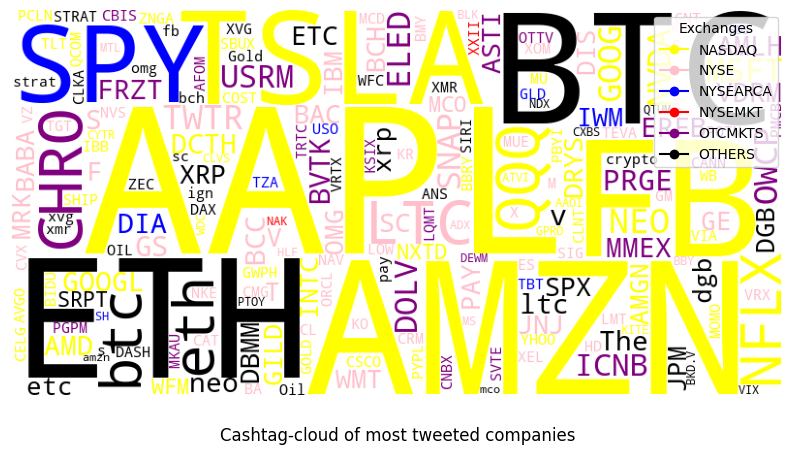

In [4]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Step 1: Read entities dataset and filter rows
filtered_df_entities = df_entities[df_entities['entity_type'] == 'symbol']

# Step 2: Create a dictionary from the filtered data
symbol_count_dict = filtered_df_entities['text'].value_counts().to_dict()

# Step 3: Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(symbol_count_dict)

# Step 4: Read companies dataset


# Step 5: Assign unique colors to exchanges
exchange_colors = {
    "NASDAQ": 'yellow',
    "NYSE": 'pink',
    "NYSEARCA": 'blue',
    "NYSEMKT": 'red',
    "OTCMKTS": 'purple',
    "OTHERS": 'black'  # Assign 'black' for "OTHERS" or missing values
}

# Step 6: Match symbols to companies and assign colors
def assign_color(ticker):
    exchange = df_companies.loc[df_companies['ticker'] == ticker, 'exchange'].values
    if len(exchange) > 0:
        exchange = exchange[0]
        return exchange_colors.get(exchange, exchange_colors["OTHERS"])
    return exchange_colors["OTHERS"]  # Assign 'black' for missing values

# Assign colors to symbols
symbol_colors = {symbol: assign_color(symbol) for symbol in symbol_count_dict.keys()}

# Step 7: Plot the word cloud with assigned colors
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud.recolor(color_func=lambda word, font_size, position, orientation, **kwargs: symbol_colors.get(word, 'red')))
plt.axis('off')

# Step 8: Create a color legend
legend_elements = [Line2D([0], [0], marker='o', color=color, label=exchange) for exchange, color in exchange_colors.items()]
plt.legend(handles=legend_elements, title='Exchanges', loc='upper right')

# Step 9: Add a title beneath the plot
plt.text(0.5, -0.1, "Cashtag-cloud of most tweeted companies", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

# Show the plot
plt.show()

### Mean tweet  per hour

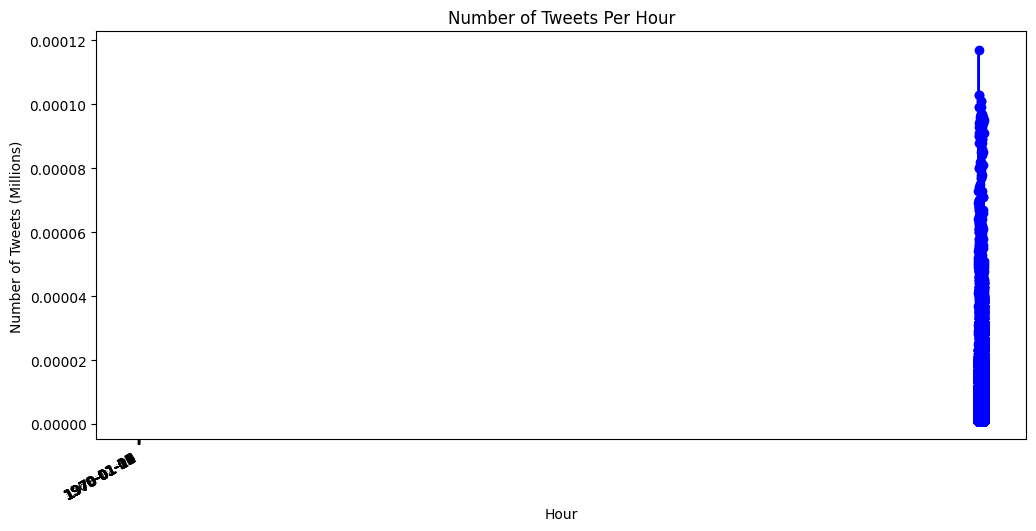

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from pytz import timezone




# Step 2: Convert the "created_at" column to datetime with a specified format
df_tweets['created_at'] = pd.to_datetime(df_tweets['created_at'], format='%a %b %d %H:%M:%S %z %Y')

# Step 3: Change the time zone to a new one (e.g., 'US/Central')
df_tweets['created_at'] = df_tweets['created_at'].dt.tz_convert('US/Central')


tweets_per_hour = df_tweets['created_at'].value_counts().sort_index()

# peak_hours = tweets_per_hour.loc[9:16].idxmax()

plt.figure(figsize=(12, 6))

tweets_per_hour = tweets_per_hour / 1000000


tweets_per_hour.plot(kind='line', marker='o', color='blue')

plt.axvspan(9, 16 , facecolor='red', alpha=0.5)

plt.title('Number of Tweets Per Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Tweets (Millions)')
plt.xticks(range(24))
plt.show()

### Distribution of the number of cashtags per tweet

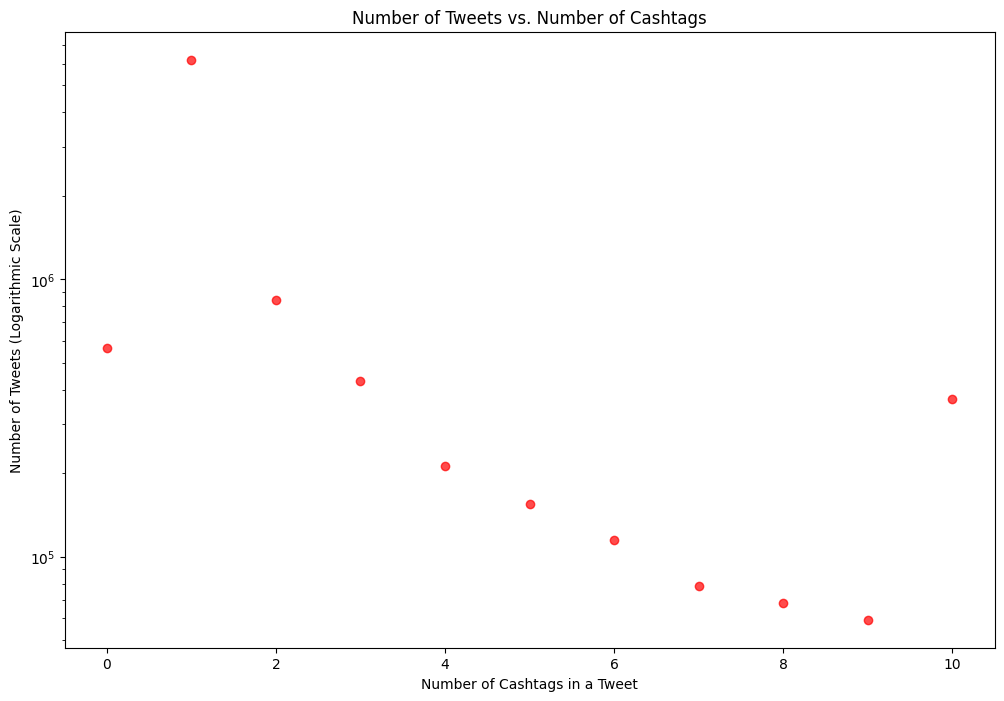

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract cashtags 
df_tweets['cashtags'] = df_tweets['text'].str.findall(r'\$[A-Z]+')

# Count the number of cashtags 
df_tweets['cashtag_count'] = df_tweets['cashtags'].apply(lambda x: len(x))

# Limit the cashtag count to a maximum of 10
df_tweets['cashtag_count'] = df_tweets['cashtag_count'].clip(upper=10)

# Count the number of tweets for each cashtag count
tweets_per_cashtag_count = df_tweets['cashtag_count'].value_counts().sort_index()

plt.figure(figsize=(12, 8))

plt.yscale('log')

plt.scatter(tweets_per_cashtag_count.index, tweets_per_cashtag_count.values, color='red', alpha=0.7)

plt.title('Number of Tweets vs. Number of Cashtags')
plt.xlabel('Number of Cashtags in a Tweet')
plt.ylabel('Number of Tweets (Logarithmic Scale)')
plt.show()

### Calculate time-series for all of Stocks

In [ ]:

# Filter symbol entities
symbol_df_entities = df_entities[df_entities['entity_type'] == 'symbol']

tweets_count_dict = {}

#Iterate and update
last_tweet_index = 0
current_date = None
current_hour = None

for index, entity_row in symbol_df_entities.iterrows():
    cashtag = entity_row['text']
    tweet_id = entity_row['tweet_id']

    while last_tweet_index < len(df_tweets) and df_tweets.at[last_tweet_index, 'id'] < tweet_id:
        current_date = pd.to_datetime(df_tweets.at[last_tweet_index, 'created_at'], format='%a %b %d %H:%M:%S %z %Y').date()
        current_hour = pd.to_datetime(df_tweets.at[last_tweet_index, 'created_at'], format='%a %b %d %H:%M:%S %z %Y').hour
        last_tweet_index += 1

    if last_tweet_index < len(df_tweets) and df_tweets.at[last_tweet_index, 'id'] == tweet_id:
        if cashtag not in tweets_count_dict:
            tweets_count_dict[cashtag] = {}

        if current_date not in tweets_count_dict[cashtag]:
            tweets_count_dict[cashtag][current_date] = {}

        if current_hour not in tweets_count_dict[cashtag][current_date]:
            tweets_count_dict[cashtag][current_date][current_hour] = 0

        tweets_count_dict[cashtag][current_date][current_hour] += 1


### save the time-series file

In [ ]:
import json

import datetime

def convert_dates_to_str(d):
    if isinstance(d, datetime.date):
        return d.strftime('%Y-%m-%d')
    elif isinstance(d, dict):
        return {convert_dates_to_str(k): convert_dates_to_str(v) for k, v in d.items()}
    elif isinstance(d, (list, tuple)):
        return [convert_dates_to_str(item) for item in d]
    return d


tweets_count_dict_str = convert_dates_to_str(tweets_count_dict)

save_path = 'dict.json'
with open(save_path, 'w') as file:
    json.dump(tweets_count_dict_str, file)

### load it

In [9]:
def convert_to_datetime(date_str, hour_str):
    if date_str.lower() == 'null':
        return None  
    if hour_str.lower() == 'null':
        hour_str = '00' 
    date_time_str = f"{date_str} {hour_str}"
    return datetime.strptime(date_time_str, "%Y-%m-%d %H")

In [10]:
import json
from datetime import datetime

file_path = 'dict.json'  
with open(file_path, 'r') as file:
    dict = json.load(file)

tweets_count_dict = {}

for cashtag, date_dict in dict.items():
    cashtag_upper = cashtag.upper()

    if cashtag_upper not in tweets_count_dict:
        tweets_count_dict[cashtag_upper] = {}

    for date_str, hour_dict in date_dict.items():
        date_time = convert_to_datetime(date_str, "00")  # Use a default hour if needed
        if date_time is not None:
            if date_time not in tweets_count_dict[cashtag_upper]:
                tweets_count_dict[cashtag_upper][date_time] = {}
            for hour_str, count in hour_dict.items():
                hour_time = datetime.strptime(hour_str, "%H")
                if hour_time.hour not in tweets_count_dict[cashtag_upper][date_time]:
                    tweets_count_dict[cashtag_upper][date_time][hour_time.hour] = count
                else:
                    tweets_count_dict[cashtag_upper][date_time][hour_time.hour] += count

### now, let's find peak hours

In [11]:
import numpy as np
from collections import defaultdict


# Initialize dictionary
average_tweets_per_hour = {}
peak_hours = defaultdict(lambda: defaultdict(set))


cashtag_counts = df_entities['text'].value_counts()

df_companies['tweet_count'] = df_companies['ticker'].map(cashtag_counts)
df_companies['tweet_count'].fillna(0, inplace=True)


top_20 = df_companies.nlargest(20, 'tweet_count')['ticker']

otc100 = df_companies[df_companies['exchange'] == 'OTCMKTS'].nlargest(100, 'tweet_count')['ticker']

random_50 = df_companies['ticker'].sample(50, replace=False)

# Combine all selected cashtags
cashtags = pd.concat([top_20, otc100, random_50]).unique()

# Iterate over each cashtag with tqdm for progress tracking
for cashtag in cashtags:
    if cashtag in tweets_count_dict:
        all_dates = list(tweets_count_dict[cashtag].keys())

        total_tweets = 0
        all_tweet_counts = []

        for date in all_dates:
            total_tweets += sum(tweets_count_dict[cashtag][date].values())
            all_tweet_counts.extend(list(tweets_count_dict[cashtag][date].values()))

        average_tweets_per_hour[cashtag] = total_tweets / len(all_tweet_counts)

        all_hours = set(hour for date in all_dates for hour in tweets_count_dict[cashtag][date])

        for date in all_dates:
            for hour in all_hours:
                tweet_count = tweets_count_dict[cashtag][date].get(hour, 0)
                if tweet_count > average_tweets_per_hour[cashtag] + 5 * np.std(all_tweet_counts + [0] * (len(all_hours) - len(all_tweet_counts))):
                    peak_hours[date][hour].add(cashtag)

print(peak_hours)

defaultdict(<function <lambda> at 0x0000019CA45ED9E0>, {datetime.datetime(2017, 6, 5, 0, 0): defaultdict(<class 'set'>, {13: {'AMZN', 'TSLA', 'SPY', 'QQQ', 'SNAP', 'AAPL', 'NVDA', 'PRGE'}, 14: {'AMZN', 'SNAP', 'AAPL', 'PRGE', 'MSFT', 'NFLX'}, 16: {'TSLA', 'SNAP'}, 17: {'PRGE', 'TSLA', 'SNAP'}, 12: {'QQQ'}, 18: {'ICLD'}}), datetime.datetime(2017, 6, 17, 0, 0): defaultdict(<class 'set'>, {13: {'FB', 'SNAP', 'CHRO', 'AAPL', 'FRZT', 'CNBX', 'MCOA', 'LQMT', 'PMCB', 'TRTC', 'OWCP', 'SVTE', 'ICNB', 'GOOG', 'VDRM'}, 14: {'SNAP', 'LQMT', 'PMCB', 'CNBX', 'SVTE'}}), datetime.datetime(2017, 6, 18, 0, 0): defaultdict(<class 'set'>, {21: {'FB', 'SNAP', 'CHRO', 'AAPL', 'FRZT', 'CNBX', 'LQMT', 'USRM', 'PMCB', 'OWCP', 'SVTE', 'ICNB', 'GOOG', 'VDRM'}}), datetime.datetime(2017, 6, 27, 0, 0): defaultdict(<class 'set'>, {16: {'SPY', 'AAPL', 'NVDA', 'OBMP', 'MSFT', 'GOOG', 'FNMA'}, 17: {'AMZN', 'SPY', 'FB', 'AAPL', 'NVDA', 'MSFT', 'GOOG'}, 10: {'QQQ'}, 13: {'QQQ'}, 6: {'MCIG'}, 19: {'CYCA', 'ECOB', 'MFST'},

### 12 most tweeted stocks

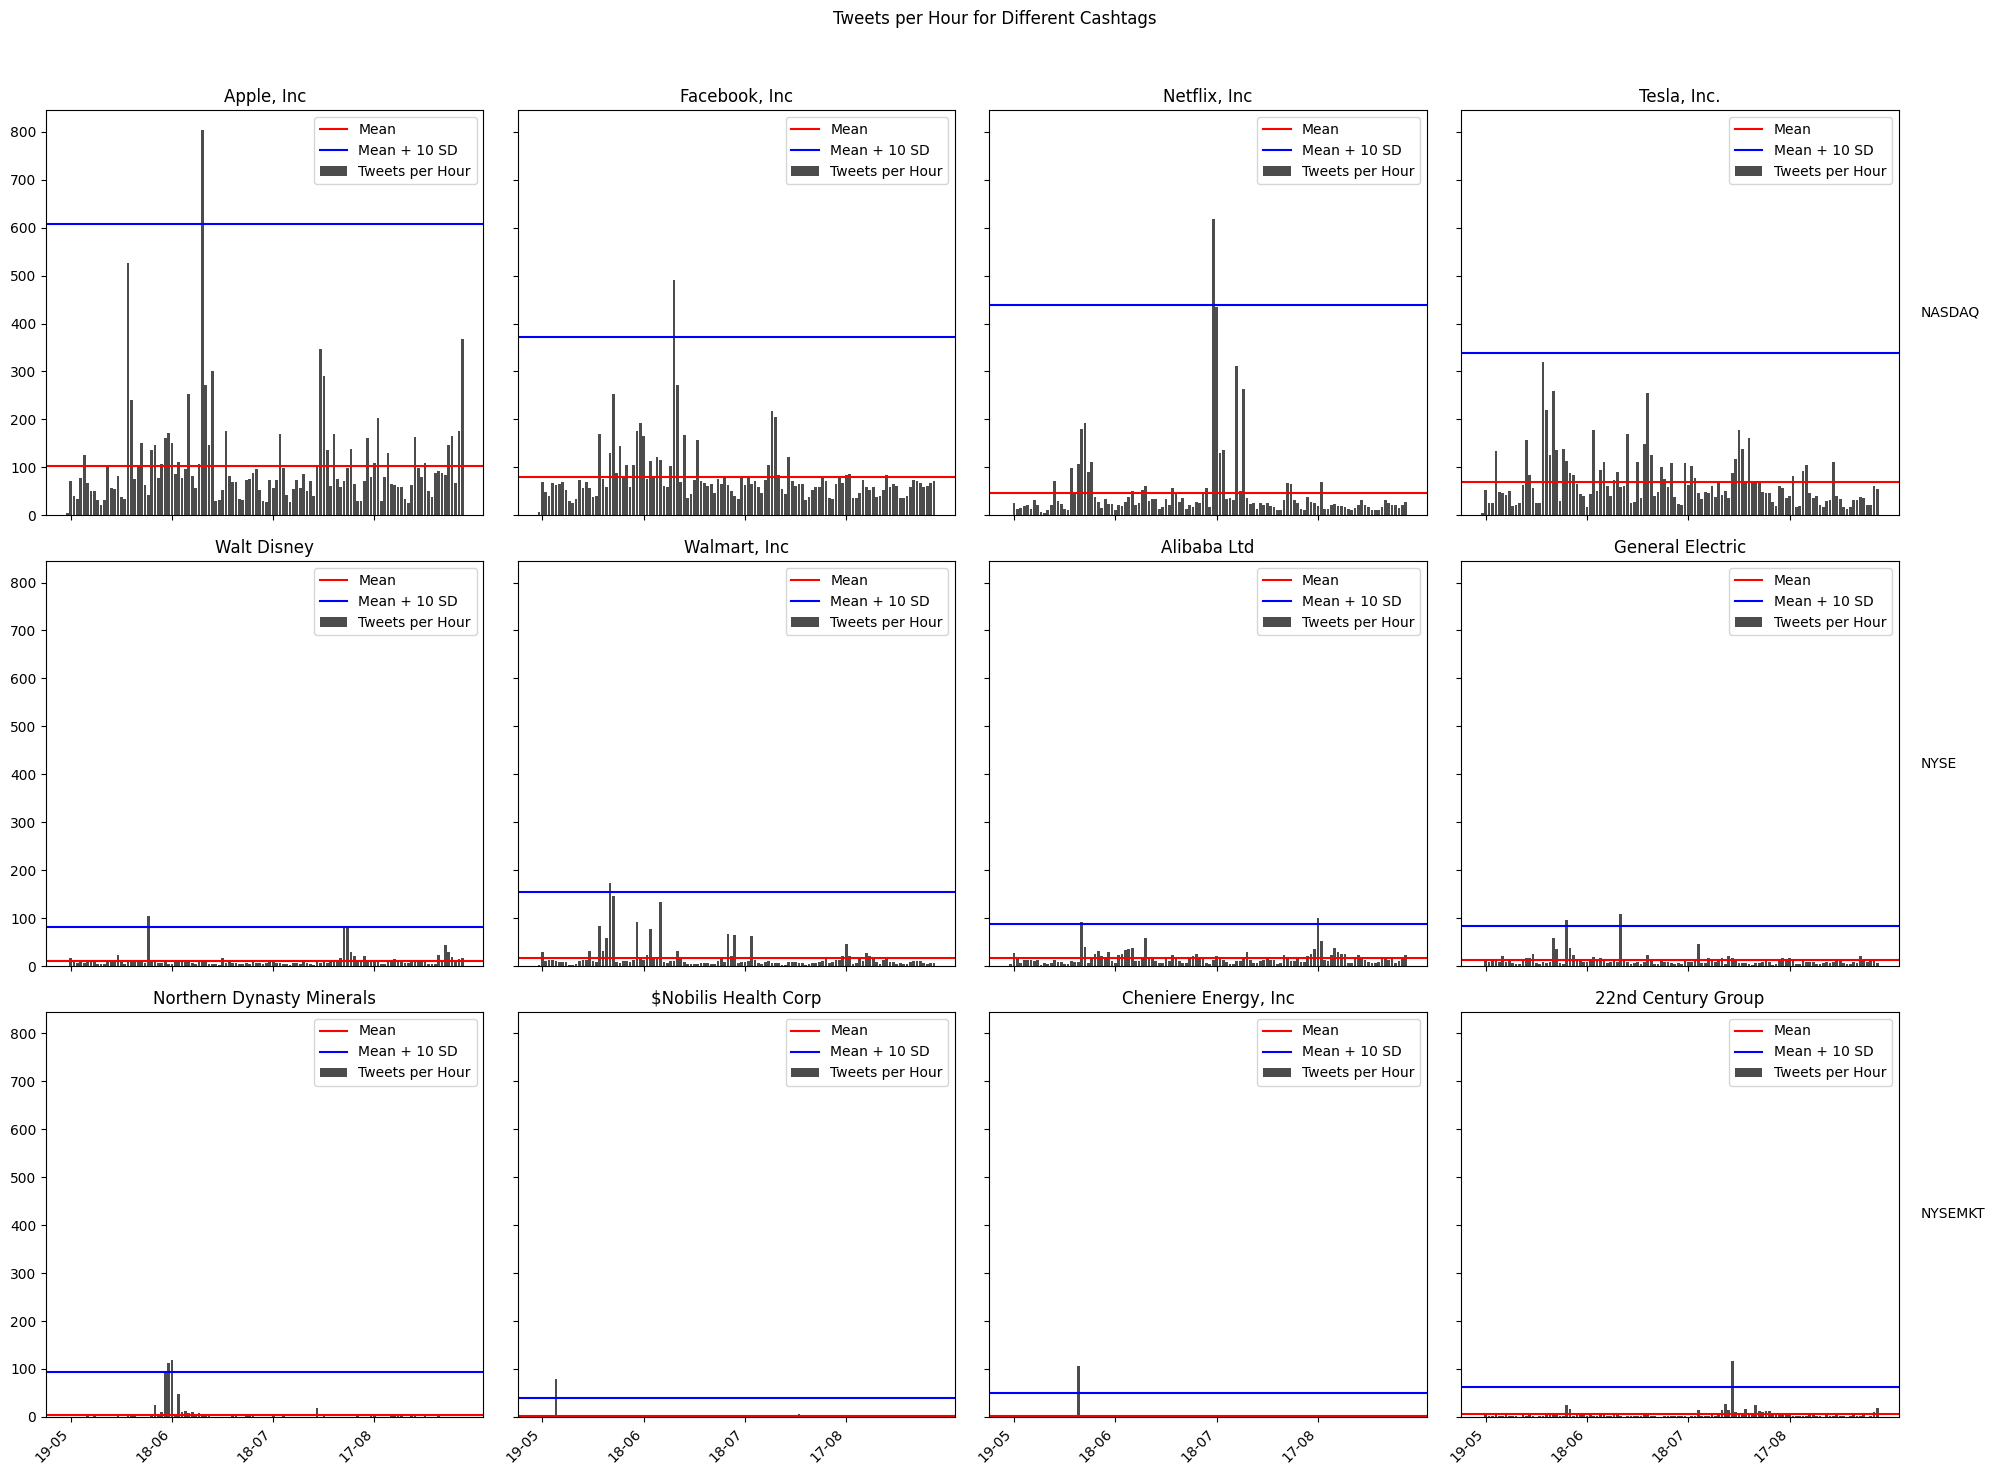

In [13]:
import matplotlib.pyplot as plt
from datetime import datetime


cashtags = ['AAPL', 'FB', 'NFLX', 'TSLA', 'DIS', 'WMT', 'BABA', 'GE', 'NAK', 'HLTH', 'LNG', 'XXII']
exchange_names = ['NASDAQ'] * 4 + ['NYSE'] * 4 + ['NYSEMKT'] * 4
plot_names = ['Apple, Inc', 'Facebook, Inc', 'Netflix, Inc', 'Tesla, Inc.',
              'Walt Disney', 'Walmart, Inc', 'Alibaba Ltd', 'General Electric',
              'Northern Dynasty Minerals', '$Nobilis Health Corp', 'Cheniere Energy, Inc', '22nd Century Group']


fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharex=True, sharey=True)
fig.suptitle('Tweets per Hour for Different Cashtags')


for i, cashtag in enumerate(cashtags):
    if cashtag in tweets_count_dict:
        ax = axes[i // 4, i % 4]

        all_dates = []
        all_daily_means = []

      
        for date in tweets_count_dict[cashtag]:
            counts = list(tweets_count_dict[cashtag][date].values())

            total_count = sum(counts)

            daily_mean = total_count / 24
            all_dates.append(date)
            all_daily_means.append(daily_mean)

        all_dates = [np.datetime64(date) for date in all_dates]

        tick_labels = pd.to_datetime(all_dates[::30]).strftime('%d-%m').tolist()
        ax.set_xticks(all_dates[::30])  
        ax.set_xticklabels(tick_labels, rotation=45, ha='right')

       
        ax.bar(all_dates, all_daily_means, label='Tweets per Hour', color='black', alpha=0.7)

        
        mean_value = np.mean(all_daily_means)
        std_dev = np.std(all_daily_means)
        upper_bound = mean_value + 5 * std_dev

        ax.axhline(mean_value, color='red', linestyle='solid', label='Mean')

        ax.axhline(upper_bound, color='blue', linestyle='solid', label='Mean + 10 SD')

        if i % 4 == 3:
            ax.text(1.05, 0.5, f'{exchange_names[i]}', transform=ax.transAxes, fontsize=10, va='center')

        ax.set_title(plot_names[i])
        ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### function to detect peak numbers

In [19]:
import random

random_cashtags = random.sample(list(dict.keys()), 100)

k_values = list(range(1, 51))
peak_counts = []


for k in k_values:
    peak_count = 0 

    for cashtag in random_cashtags:
        cashtag_upper = cashtag.upper()

        hourly_tweet_counts = []

        for date_str, hour_dict in dict[cashtag].items():
            date_time = convert_to_datetime(date_str, "00")  # Use a default hour if needed
            if date_time is not None:
                hourly_tweet_counts.extend(list(hour_dict.values()))

        average_tweets_per_hour = np.mean(hourly_tweet_counts)

        for date_str, hour_dict in dict[cashtag].items():
            for count in hour_dict.values():
                if count > average_tweets_per_hour + k * np.std(hourly_tweet_counts):
                    peak_count += 1

    peak_counts.append(peak_count)

# Plot the number of peaks for each K value
plt.plot(k_values, peak_counts, marker='o', color='blue', linestyle='-', markersize=5)
plt.title('Peak Hours for Different K')
plt.xlabel('K')
plt.ylabel('Peak Hours')
plt.grid(True)
plt.show()

TypeError: unbound method dict.keys() needs an argument